# Training Neural Networks

The network we built in Part 1 is dumb, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
C = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial C}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial C}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial C}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. For PyTorch to track operations, you need to wrap a tensor with the `Variable` class from `torch.autograd`. You can get the tensor back with the `.data` attribute of the Variable.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import helper

In [2]:
x = torch.ones(2,2)
x = Variable(x, requires_grad=True)
x

tensor([[ 1.,  1.],
        [ 1.,  1.]])

In [3]:
y = 3*(x+1)**2
y

tensor([[ 12.,  12.],
        [ 12.,  12.]])

Below we can see the operation that created `y`, a `MulConstant` op.

In [4]:
## grad_fn shows the function that generated this variable
y.grad_fn

In [5]:
z = y.mean()
z

tensor(12.)

Again, we can check out how `z` was created, with a `Mean` operation.

In [6]:
z.grad_fn

Since we haven't performed a backward pass, `x` doesn't have a gradient yet.

In [7]:
x.grad

Now we can calculate the gradients of `z` with respect to `x` with `z.backward()`.

In [8]:
z.backward()
x.grad

tensor([[ 3.,  3.],
        [ 3.,  3.]])

These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [9]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [10]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 200, 50, 10 units each
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 50)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits)

In [11]:
net = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [12]:
print('Initial weights - ', net.fc1.weight)

dataiter = iter(trainloader)
images, labels = dataiter.next()

images.resize_(64, 784)

# Create Variables for the inputs and targets
inputs = Variable(images)
targets = Variable(labels)

# Clear the gradients from all Variables
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = net.forward(inputs)
loss = criterion(output, targets)
loss.backward()
print('Gradient -', net.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[ 1.3705e-02, -1.1845e-02,  3.5593e-02,  ...,  7.1031e-03,
          1.3307e-02, -4.6098e-03],
        [ 2.7660e-02,  3.9479e-03,  1.2626e-02,  ..., -5.2614e-03,
          1.0493e-03,  2.3678e-02],
        [-2.5106e-03, -8.0797e-03, -3.4879e-02,  ..., -3.2479e-03,
         -6.6071e-03, -3.5182e-02],
        ...,
        [-4.6291e-03,  1.6612e-02, -3.5645e-02,  ...,  1.0711e-02,
         -2.8256e-02, -2.2569e-02],
        [-2.2392e-02,  3.4220e-02,  1.3116e-02,  ...,  1.7722e-02,
         -1.9565e-02, -1.8259e-02],
        [-2.8018e-02, -2.2434e-02, -2.6447e-02,  ..., -8.5385e-03,
          3.3591e-02,  2.8966e-02]])
Gradient - tensor(1.00000e-02 *
       [[-0.1484, -0.1484, -0.1484,  ..., -0.1484, -0.1484, -0.1484],
        [-0.2542, -0.2542, -0.2542,  ..., -0.2542, -0.2542, -0.2542],
        [ 0.0258,  0.0258,  0.0258,  ...,  0.0258,  0.0258,  0.0258],
        ...,
        [ 0.0423,  0.0423,  0.0423,  ...,  0.0423,  0.0423,  0.0423],
  

In [13]:
print('Updated weights - ', net.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 1.3720e-02, -1.1830e-02,  3.5608e-02,  ...,  7.1180e-03,
          1.3322e-02, -4.5950e-03],
        [ 2.7686e-02,  3.9734e-03,  1.2652e-02,  ..., -5.2360e-03,
          1.0747e-03,  2.3703e-02],
        [-2.5131e-03, -8.0823e-03, -3.4881e-02,  ..., -3.2505e-03,
         -6.6097e-03, -3.5184e-02],
        ...,
        [-4.6333e-03,  1.6608e-02, -3.5650e-02,  ...,  1.0707e-02,
         -2.8260e-02, -2.2574e-02],
        [-2.2423e-02,  3.4189e-02,  1.3086e-02,  ...,  1.7691e-02,
         -1.9596e-02, -1.8289e-02],
        [-2.8012e-02, -2.2428e-02, -2.6441e-02,  ..., -8.5325e-03,
          3.3597e-02,  2.8972e-02]])


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer

In [14]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
for e in range(epochs):
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)

        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                
                predicted = net.predict(inputs).data
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/1 Loss: 0.2050 Test accuracy: 0.9367
Epoch: 1/1 Loss: 0.2363 Test accuracy: 0.9403
Epoch: 1/1 Loss: 0.2225 Test accuracy: 0.9303
Epoch: 1/1 Loss: 0.2826 Test accuracy: 0.9361
Epoch: 1/1 Loss: 0.2574 Test accuracy: 0.9436
Epoch: 1/1 Loss: 0.1873 Test accuracy: 0.9345
Epoch: 1/1 Loss: 0.1740 Test accuracy: 0.9373
Epoch: 1/1 Loss: 0.2315 Test accuracy: 0.9392
Epoch: 1/1 Loss: 0.1664 Test accuracy: 0.9422
Epoch: 1/1 Loss: 0.2007 Test accuracy: 0.9371
Epoch: 1/1 Loss: 0.1660 Test accuracy: 0.9406
Epoch: 1/1 Loss: 0.1994 Test accuracy: 0.9403
Epoch: 1/1 Loss: 0.1939 Test accuracy: 0.9429
Epoch: 1/1 Loss: 0.2500 Test accuracy: 0.9416
Epoch: 1/1 Loss: 0.1736 Test accuracy: 0.9357
Epoch: 1/1 Loss: 0.2101 Test accuracy: 0.9376
Epoch: 1/1 Loss: 0.1857 Test accuracy: 0.9418
Epoch: 1/1 Loss: 0.2055 Test accuracy: 0.9382
Epoch: 1/1 Loss: 0.1578 Test accuracy: 0.9447
Epoch: 1/1 Loss: 0.1471 Test accuracy: 0.9424
Epoch: 1/1 Loss: 0.1364 Test accuracy: 0.9398
Epoch: 1/1 Loss: 0.2126 Test accur

In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


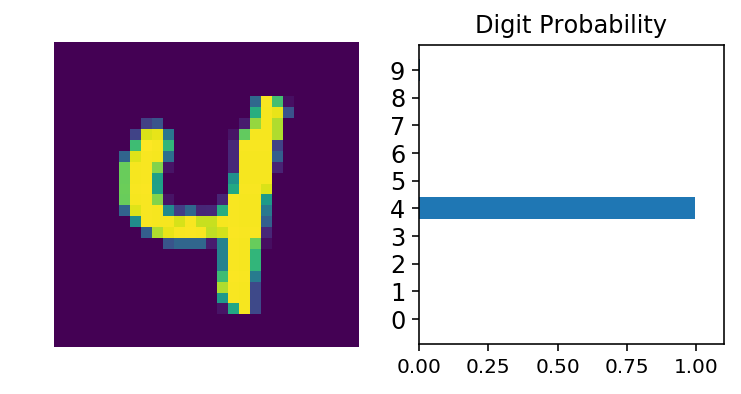

In [18]:
img = images[0]
ps = net.predict(Variable(img.resize_(1, 784)))
helper.view_classify(img.resize_(1, 28, 28), ps)

## Convolutional Networks

<img src='assets/padding_strides.gif'>

Next we'll check out how to build a **convolutional network** to classify MNIST images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.

Traditionally, convolutional layers are followed by max-pooling, where values in the convolutional layer are aggregated into a smaller layer. 

<img src='assets/Pooling_Simple_max.png' width=600px>

These types of networks become really useful when you stack a bunch of layers, you make the network *deeper*. Typically you'll use a convolutional layer to change the depth, ReLU activation, then a max-pooling layer to reduce the height and width.

<img src='assets/conv_net.jpg' width=600px>

To finish off the network, you need to flatten the final convolutional layer into a normal fully-connected (dense) layer, then add more fully-connected layers as a classifier. The convolutional layers act as feature detectors that the classifier uses as inputs. Convolutional networks have been massively effective in image classification, object recognition, and even in natural language processing applications like speech generation.

Building this new network is pretty much the same as before, but we use `nn.Conv2d` for the convolutional layers and `nn.MaxPool2d` for the max-pooling layer. (Although max-pooling has fallen out of favor recently, but this is traditional so let's stick with it.)

So here I'll build a convolutional network with two convolutional layers, with ReLU activations, and max-pooling after each. The first convolutional layer will have a depth of 10, use a 5x5 kernel, with a stride of 1 (so no downsampling). The second convolutional layer will have a depth of 20, use a 5x5 kernel, and a stride of 1 again. Both layers will have "same" padding, but it's done differently here than in TensorFlow. Instead of saying we want "same" padding and letting the framework pad the input tensors, we define how much padding we want on the tensors. The padding should be set to 2 then, since we are using 5x5 kernels and we want the center of the kernel to lie on the edges of the images. Then, there will be two pixels of the kernel falling over the edge of the images.

We'll flatten the final convolutional layer and pass it to a fully connected layer. We can change the shape of the Variable `x` with `x.view`. This is then passed to the fully connected layer, which then goes to the output layer with 10 units.

In [22]:
class ConvNet(nn.Module):
    def __init__(self, n_conv1=10, n_conv2=20):
        super().__init__()
        
        self.n_conv1, self.n_conv2 = n_conv1, n_conv2
        
        # conv layer with depth n_conv1, 5x5 kernels, and "same" padding
        self.conv1 = nn.Conv2d(1, n_conv1, 5, padding=2)
        # conv layer with depth n_conv2, 5x5 kernels, and "same" padding
        self.conv2 = nn.Conv2d(n_conv1, n_conv2, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        
        # The second convolutional layer will have size [7, 7, n_conv2], fc1 flattens it
        self.fc1 = nn.Linear(n_conv2*7*7, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        # First conv layer, then ReLU, then max-pooling
        x = F.relu(self.pool(self.conv1(x)))
        # Second conv layer, then ReLU, then max-pooling
        x = F.relu(self.pool(self.conv2(x)))
        # Flatten conv layer by reshaping
        x = x.view(-1, self.n_conv2*7*7)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = F.relu(self.fc3(x))
        
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [25]:
net = ConvNet()
trainloader.batch_size = 128
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)



epochs = 1
steps = 0
running_loss = 0
print_every = 20
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        
        steps += 1

        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                #images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                
                predicted = net.predict(inputs).data
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

ValueError: batch_size attribute should not be set after DataLoader is initialized

## Speeding things up

We can greatly speed up our training by running the matrix operations on a GPU with CUDA. In PyTorch, we do this by sending the tensors to the GPU. First, you set the network to use the GPU with `net.cuda()`. Then, the input and target tensors are sent to the GPU, typically with some flag

```
if cuda == True:
    inputs, targets = inputs.cuda(), targets.cuda()
```

And that's it. The output of the network will again be a tensor on the GPU, so to get it back to the CPU for further operations (such as with Numpy), you use `output = output.cpu()`. Similarly, to set the network back to running on the CPU, use `net.cpu()`.

In [21]:
net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.cuda()

trainloader.batch_size = 128
epochs = 5
steps = 0
running_loss = 0
print_every = 50
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        
        steps += 1

        inputs = Variable(images)
        targets = Variable(labels)
        
        inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                inputs = Variable(images, volatile=True)
                inputs = inputs.cuda()
                
                # Get the class prediction and bring it back to the CPU
                predicted = net.predict(inputs).data.cpu()
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

ValueError: batch_size attribute should not be set after DataLoader is initialized

## Saving and loading models

Now that we know how to build and train models, we actually need to be able to use these things after training. The general way to do this is building a dictionary with hyperparameters such as sizes of the convolutional layers and such. The parameters and other information needed to rebuild the model are stored in `net.state_dict()`. Then you build a dictionary that looks something like

```python
checkpoint = {'n_conv1': 10,
              'n_conv2': 20,
              'state_dict': model.state_dict()}
```

You save this check point to a file with `torch.save(checkpoint, file_object)`.

Then, to load a checkpoint, use `torch.load`. This loads the whole dictionary so you have the hyperparameters to rebuild the network as well as `state_dict` which contains the values for weights and such.

In [ ]:
## Save the model
filename = 'mnist1.ckpt'
checkpoint = {'n_conv1': net.n_conv1,
              'n_conv2': net.n_conv2,
              'state_dict': net.state_dict()}
with open(filename, 'wb') as f:
    torch.save(checkpoint, f)

In [ ]:
## Load the model
filename = 'mnist1.ckpt'
with open(filename, 'rb') as f:
        checkpoint = torch.load(f)

model = ConvNet(n_conv1=checkpoint['n_conv1'],
                n_conv2=checkpoint['n_conv2'])
model.load_state_dict(checkpoint['state_dict'])

In [ ]:
dataiter = iter(testloader)

In [ ]:
images, labels = dataiter.next()
img = images[0]
ps = model.predict(Variable(img.resize_(1, *img.size())))
helper.view_classify(img, ps)